In [ ]:
# 
# 

In [4]:
import os
from os import makedirs
import zipfile
import numpy as np 
import pandas as pd 
from shutil import rmtree

In [5]:

def make_directory(dir_path):
    if os.path.exists(dir_path):
        rmtree(dir_path)
    makedirs(dir_path)
    print(dir_path, ' folder is created')
    
input_zip_dir = '../input/dogs-vs-cats'
base_dir = '../output/cats-vs-dogs'
tmp_dir = '../output/tmp'

make_directory(base_dir)
make_directory(tmp_dir)

# extract train data
zip_ref = zipfile.ZipFile(os.path.join(input_zip_dir,'train.zip'), 'r')
zip_ref.extractall(tmp_dir)
zip_ref.close()
print('Done')

../output/cats-vs-dogs  folder is created
../output/tmp  folder is created
Done


In [6]:
print('Creating folders ....')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
make_directory(train_dir)
make_directory(test_dir)


Creating folders ....
../output/cats-vs-dogs/train  folder is created
../output/cats-vs-dogs/test  folder is created


In [7]:
list_of_fnames = os.listdir(os.path.join(tmp_dir,'train'))
print('Total number of of images in tmp/train is {0}'.format(len(list_of_fnames)))
list_of_cats_fnames = [i for i in list_of_fnames if 'CAT' in i.upper()]
list_of_dogs_fnames = [i for i in list_of_fnames if 'DOG' in i.upper()]
TOTAL_CATS = len(list_of_cats_fnames)
TOTAL_DOGS = len(list_of_dogs_fnames)
print('{0} CATS images'.format(TOTAL_CATS))
print('{0} DOGS images'.format(TOTAL_DOGS))

Total number of of images in tmp/train is 25000
12500 CATS images
12500 DOGS images


In [8]:
TRAIN_TEST_SPLIT_AT = 0.9
BATCH_SIZE = 128
TARGET_SIZE = (128, 128)
NO_OF_EPOCHS = 1
EXPERIMENT_SIZE = 10000
NO_OF_FOLDS = 3

In [9]:
print('\nDistributing images to \n {0} \n {1} \n'
      '\nsuch that {2}% of total number of images goes to training and \n'
      '{3}% goes to test'.format(
    train_dir,test_dir,
    round(TRAIN_TEST_SPLIT_AT * 100),
    round((1 - TRAIN_TEST_SPLIT_AT) * 100)))


Distributing images to 
 ../output/cats-vs-dogs/train 
 ../output/cats-vs-dogs/test 

such that 90% of total number of images goes to training and 
10% goes to test


In [10]:
# Copy images from tmp_dir to train/Cats, train/Dogs and to validation/Cats and validation/Dogs
# according to the split percentage we decided.

from shutil import copyfile

np.random.shuffle(list_of_cats_fnames)
np.random.shuffle(list_of_dogs_fnames)

tmp_train_dir = os.path.join(tmp_dir, 'train')
c = 0
for i in list_of_cats_fnames:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(train_dir, i))
    else:
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(test_dir, i))
    c += 1
    if c >= EXPERIMENT_SIZE:
        break

c = 0
for i in list_of_dogs_fnames:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(train_dir, i))
    else:
        copyfile(os.path.join(tmp_train_dir, i), os.path.join(test_dir, i))
    c += 1
    if c >= EXPERIMENT_SIZE:
        break

print('Total training cat images :', len(os.listdir(train_dir)))
print('Total test dog images :', len(os.listdir(test_dir)))

Total training cat images : 18000
Total test dog images : 2000


In [11]:
# Creat train_X for a numpy array for training images file names and create correpsonding train_labels
train_X = [img_fname for img_fname in os.listdir(train_dir)]
train_X = np.array(train_X)
# 
train_labels = [l.split('/')[-1].split('.')[0].strip('0123456789') for l in train_X]
train_labels = np.array(train_labels)
# 
print ('Training shape:', train_X.shape, train_labels.shape) 
# 
print(train_X[:5], train_labels[:5])


Training shape: (18000,) (18000,)
['dog.890.jpg' 'dog.1178.jpg' 'dog.4632.jpg' 'dog.814.jpg' 'dog.2066.jpg'] ['dog' 'dog' 'dog' 'dog' 'dog']


In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
print('Constructing and compiling model ...')
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print('Done')

Constructing and compiling model ...
Done


In [13]:
if tf.test.is_gpu_available():
    # Force TensorFlow to use the GPU
    config = tf.compat.v1.ConfigProto(device_count={'GPU': 1})
    config.gpu_options.allow_growth = True  # Allow GPU memory growth
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
else:
    print("No GPU available, using CPU.")

In [14]:
from keras.preprocessing.image import ImageDataGenerator
import sklearn.model_selection as sklrn

def train_and_cross_validate (model, x_data, y_data, n_folds=NO_OF_FOLDS, epochs=NO_OF_EPOCHS, batch_size=BATCH_SIZE):
    # 
    scores = []
    
    #  Loading images through generators ...
    train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)    
    validation_datagen = ImageDataGenerator(rescale=1. / 255)
          
    # prepare cross validation
    kfold = sklrn.KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    FoldsSetNo = 0 
    for train_ix, test_ix in kfold.split(x_data):
        print ('Folds Set # {0}'.format(FoldsSetNo))
        # select rows for train and test
        xx_train, yy_train, xx_test, yy_test = \
            x_data[train_ix], y_data[train_ix], x_data[test_ix], y_data[test_ix]

        # flow training images in batches for the current folds set
        # for training         
        train_generator = train_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_train,'label':yy_train}), 
            directory=train_dir, 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=TARGET_SIZE,
            class_mode='binary',
            shuffle = False)
        
        # and for validation         
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_test,'label':yy_test}), 
            directory=train_dir, 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=TARGET_SIZE,
            class_mode='binary',
            shuffle=False)

        # fit the model
        history = model.fit(train_generator,
                            epochs=epochs,  # The more we train the more our model fits the data
                            batch_size=batch_size,  # Smaller batch sizes = samller steps towards convergence
                            validation_data=validation_generator,
                            verbose=1)
        # store scores
        scores.append({'acc':np.average(history.history['accuracy']),'val_acc':np.average(history.history['val_accuracy'])})
        FoldsSetNo +=1
    return scores
print('Starting training and k-fold cross validation ...')
scores = train_and_cross_validate(model, train_X, train_labels)

Starting training and k-fold cross validation ...
Folds Set # 0
Found 12000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
94/94 [==============================] - 80s 852ms/step - loss: 0.6957 - accuracy: 0.5572 - val_loss: 0.6388 - val_accuracy: 0.6562
Folds Set # 1
Found 12000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
94/94 [==============================] - 80s 849ms/step - loss: 0.6453 - accuracy: 0.6257 - val_loss: 0.5871 - val_accuracy: 0.6972
Folds Set # 2
Found 12000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
94/94 [==============================] - 79s 845ms/step - loss: 0.6165 - accuracy: 0.6569 - val_loss: 0.5905 - val_accuracy: 0.6885


[0.5571666955947876, 0.6256666779518127, 0.6569166779518127]
[0.656166672706604, 0.6971666812896729, 0.6884999871253967]


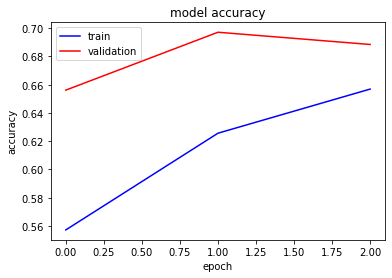

In [15]:
from matplotlib import pyplot as plt
# summarize history for accuracy
# print(scores)
train = []
validation = []
plt.subplot(1, 1, 1)
for s in scores:
    train.append(s['acc'])
    validation.append(s['val_acc'])
print(train)
print(validation)
plt.plot(train, color='blue', label='train')
plt.plot(validation , color='red', label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show() #